Pump unit is exposed to typical bearing failures, water/oil leaks, and electrical faults. Reactive maintenance results in higher downtime, higher repair cost and high safety risks. Preventive maintenance consists of carrying out maintenance regularly, following a precise schedule, this approach significantly reduces the chances of failure however it is still very inefficient in terms of cost and time because of the unnecessary maintenance performed. Predictive maintenance helps to estimate when maintenance should be performed and helps avoiding break down, repair cost, safety risks and unnecessary regular maintenance.
In this case study we will build an end to end Machine Learning model to predict the pump status given an input so that appropriate action can be taken.

# 1. Business Problem
Small team is taking care of water pumps in a small area far from a big town. In the previous year, the pump system failed 7 times. These failures cause huge problems to many people and also in some cases serious injuries.
Goal is to predict future failure of water pumps using sensor’s historical data, allowing the team to react proactively and plan the most appropriate maintenance solution.

# 2. ML Formulation
It is a Binary Classification problem. Using sensor’s historical data carryout time series analysis, given new data point classify them as positive class (Borken) or negative class (Normal)

# 3. Performance Metrics
In this case study equal importance is given to both the classes because if the model predicts postitive class as negative, it leads to break down, repair cost and safety issues similarly if the model predicts negative class as positive then it results in unnecessary maintenace.

Therefore Macro F1-Score and Confusion Matrix is used as performance metrics
Macro F1-Score is calculated by calculating F1-Score for each class and then taking their average thereby giving equal importance to both the classes.

Confusion Matrix helps us to visualize model performance. It gives count of correctly classified points and misclassified points for each classes.

# 4. Data Overview:


In [4]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt                                                 
import seaborn as sns 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from prettytable import PrettyTable

import warnings
warnings.filterwarnings("ignore")

In [5]:
import zipfile
with zipfile.ZipFile("pump_sensor.zip","r") as zip_ref:
    zip_ref.extractall("")

In [7]:
sensor_data = pd.read_csv('pump_sensor.csv')
sensor_data.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [8]:
sensor_data.tail()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
220315,220315,2018-08-31 23:55:00,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,...,38.28125,68.28703,52.37268,48.32176,41.087960,212.3843,153.6458,NaN,231.1921,NORMAL
220316,220316,2018-08-31 23:56:00,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,...,38.28125,66.84028,50.63657,48.03241,40.798610,213.8310,156.2500,NaN,231.1921,NORMAL
220317,220317,2018-08-31 23:57:00,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,...,39.06250,65.39352,48.90046,48.03241,40.798610,217.3032,155.3819,NaN,232.0602,NORMAL
220318,220318,2018-08-31 23:58:00,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,...,40.62500,64.23611,47.74306,48.32176,40.509258,222.5116,153.9352,NaN,234.0856,NORMAL
220319,220319,2018-08-31 23:59:00,2.396528,47.69965,50.520832,43.142361,639.814800,65.45634,15.11863,16.65220,...,41.40625,62.78935,46.29630,48.90046,40.219910,227.4306,150.4630,NaN,234.0856,NORMAL


In [9]:
print('All the columns:')
print()
print(sensor_data.columns)

All the columns:

Index(['Unnamed: 0', 'timestamp', 'sensor_00', 'sensor_01', 'sensor_02',
       'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07',
       'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12',
       'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17',
       'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22',
       'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27',
       'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32',
       'sensor_33', 'sensor_34', 'sensor_35', 'sensor_36', 'sensor_37',
       'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42',
       'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47',
       'sensor_48', 'sensor_49', 'sensor_50', 'sensor_51', 'machine_status'],
      dtype='object')


In [10]:
# total number of data points
sensor_data.shape

(220320, 55)

**Observations:**

* Dataset contains 220320 data points
* Data contains readings from 52 sensors and corresponding time stamps
* Sensor data of 5 months from April to August is provided. Each row contains sensor readings after every minute
* What parameter each sensor is measuring is not specified

# 5. EDA & Data Pre-processing


In [11]:
def get_class_distribution(df, col=None):
    """
    Function to plot class distribution
    """
    if col == 'machine_status': # if column = machine_status
        # Counting class labels
        label_count = df['machine_status'].value_counts() 
    elif col == 'label': # if column = label
        label_count = df['label'].value_counts()
    else:
        label_count = df.value_counts()
    # bar plot
    plot = sns.barplot(list(label_count.index), list(label_count.values)) 
    plt.title('Class Distribution')
    plt.xlabel('Class Label')
    plt.ylabel('Count')

    # adding class count to the barplot
    for patch in plot.patches:
        # formatting and positioning the count values
        plot.annotate('{:n}'.format(patch.get_height()), 
                      (patch.get_x()+0.25, patch.get_height()+1)) 
    plt.show()

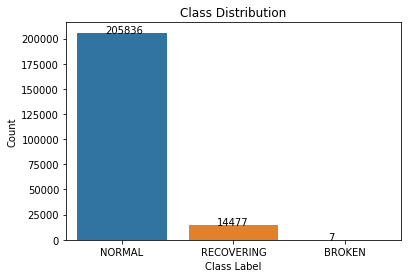

In [12]:
get_class_distribution(sensor_data, 'machine_status')

Observations:

* 205836 data points belongs to class Normal
* 14477 data points belongs to class Recovering
* 7 data points belongs to class Broken

### Machine Status


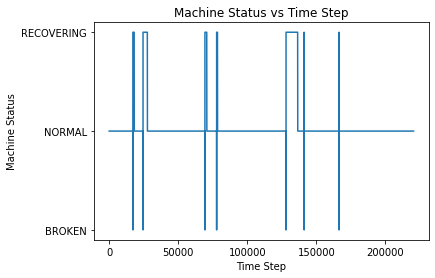

In [13]:
# label encoding
le = preprocessing.LabelEncoder() # creating label encoder
y = le.fit_transform(sensor_data['machine_status']) # fitting on labels
x = list(sensor_data.index)
plt.plot(x, y)
plt.xlabel('Time Step')
plt.ylabel('Machine Status')
plt.title('Machine Status vs Time Step')

encode_labels = list(le.transform(list(le.classes_))) # encoded labels
labels = list(le.classes_) # labels
plt.yticks(encode_labels, labels)
plt.show()

**Observations:**
* From the above plot we can see that RECOVERING state follows BROKEN state
* In RECOVERING state, pump is trying to recover from BROKEN state
* So RECOVERING state is also considered as BROKEN statem

### Relabeling the data


Class distribution after re-labeling the data



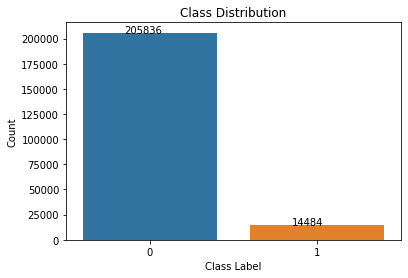


----------------------------------------------------------------------
Machine status after re-labeling the data



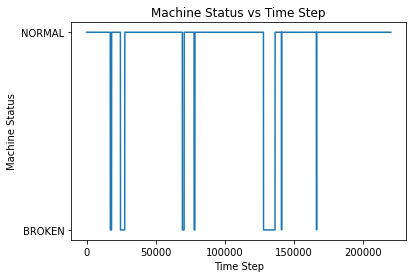

In [14]:
# encoding labels as 0 and 1
# 0 = normal
# 1 = broken
sensor_data['label'] = sensor_data['machine_status'].map(lambda label: 0
                                                if label == 'NORMAL' else 1) 

print("Class distribution after re-labeling the data")
print()
get_class_distribution(sensor_data, 'label')
print()
# print('-*'*40)
print('-'*70)

# changing machine status recovery to broken
sensor_data['new_machine_status'] = sensor_data['machine_status'].map(lambda 
                        label:  'BROKEN' if label != 'NORMAL' else 'NORMAL')


print("Machine status after re-labeling the data")
print()
x = list(sensor_data.index) # fitting on labels

# reversing labels for better visualization
y = list(sensor_data['label'].map(lambda label:  1 if label == 0 else 0))

plt.plot(x, y)
plt.xlabel('Time Step')
plt.ylabel('Machine Status')
plt.title('Machine Status vs Time Step')

encode_labels = [0, 1] # encoded labels
labels = ['BROKEN', 'NORMAL'] # labels 
plt.yticks(encode_labels, labels)
plt.show()

**Observations**:
* Number of NORMAL(label = 0) class points = 205836
* Number of BROKEN(label = 1) class points = 14484

## Missing Values:


Missing Value Count



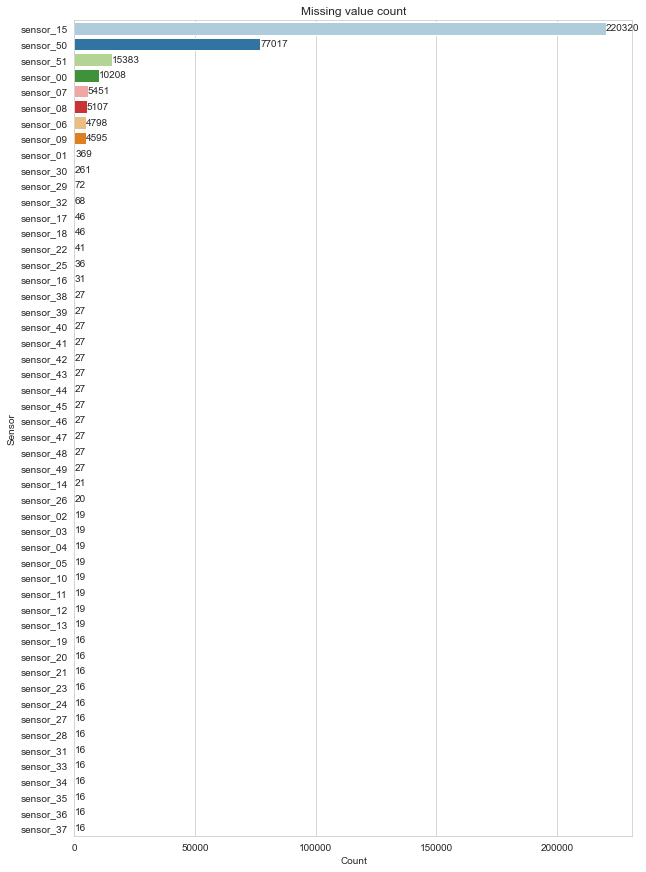

In [15]:
print("Missing Value Count")
print()
null_count = sensor_data.isna().sum()# count null values
# considering only sensor columns
null_count = null_count[2:-3] 

count_dict = {}

# creating dictionary of column and null value count
for i, j in zip(null_count.index, null_count.values):
    count_dict[i] = j

# sorting the dictionary
count_dict = {k:v for k, v in sorted(count_dict.items(), 
                                     key=lambda item: item[1], reverse=True)}
sns.set_style(style="whitegrid")
plt.figure(figsize=(10,15))
plot = sns.barplot(x=list(count_dict.values()), 
                   y=list(count_dict.keys()), palette='Paired')

# ref: https://stackoverflow.com/questions/43214978/seaborn-
# barplot-displaying-values/51535326#51535326
for p in plot.patches:
    _x = p.get_x() + p.get_width() + 0.5 # adjusting the label along x axis
    _y = p.get_y() + p.get_height() - 0.25 # adjusting the label along y axis
    value = int(p.get_width())
    plot.text(_x, _y, value, ha="left")

plot.set_title("Missing value count")
plot.set_ylabel("Sensor")
plot.set_xlabel("Count")
plt.show()

Percentage Missing Values 



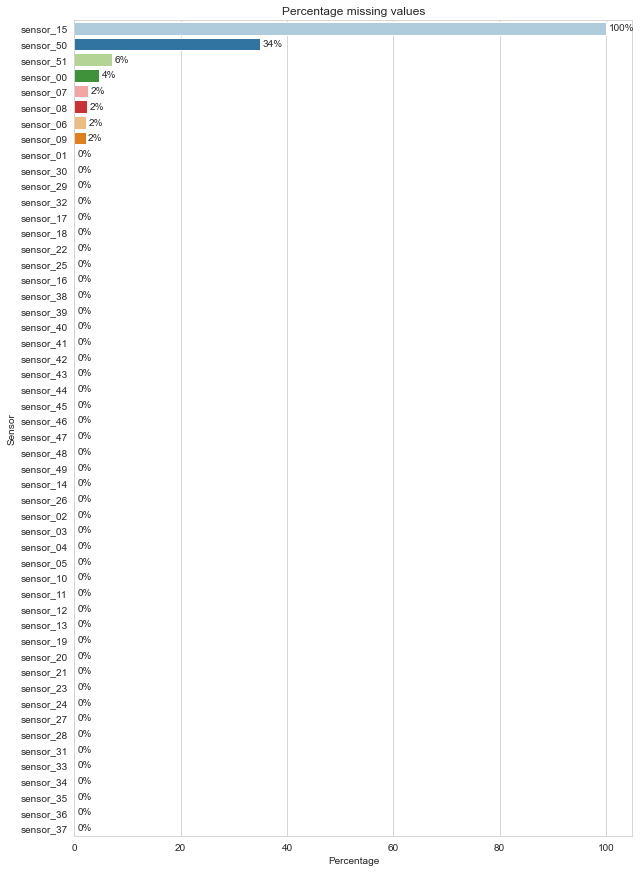

In [16]:
print("Percentage Missing Values ")
print()

# percentage null values
null_count = sensor_data.isna().sum()/sensor_data.shape[0] * 100 
null_count = null_count[2:-3] # considering only sensor columns

percent_null = {}

# creating dictionary of column and percentage null value
for i, j in zip(null_count.index, null_count.values):
    percent_null[i] = j

# sorting the dictionary
percent_null = {k:v for k, v in sorted(percent_null.items(), 
                                       key=lambda item: item[1], reverse=True)}

sns.set_style(style="whitegrid")
plt.figure(figsize=(10,15))

plot = sns.barplot(x=list(percent_null.values()), 
                   y=list(percent_null.keys()), palette='Paired')

# ref: https://stackoverflow.com/questions/43214978/seaborn-barplot-
# displaying-values/51535326#51535326
for p in plot.patches:
    _x = p.get_x() + p.get_width() + 0.5
    _y = p.get_y() + p.get_height() - 0.25
    value = f'{int(p.get_width())}%'
    plot.text(_x, _y, value, ha="left")

plot.set_title("Percentage missing values")
plot.set_ylabel("Sensor")
plot.set_xlabel("Percentage")
plt.show()

**Obeservations**:
* all the sensors have missing values
* all of the sensor_15 readings are missing
* 34% of sensor_50 readings are missing
* sensor_51 is having 6% missing values
* 4% of sensor_00 readings are missing
* sensor_07, sensor_08, sensor_06, sensor_09 have 2% missing values
* all other sensor have less than 1% missing values

In [17]:
def plot_missing (sensor_num, df):
    """
    Function to plot machine status, sensor readings variation with time
    Also to plot missing values
    """
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[[sensor_num]])
    null_sensor = df[df[sensor_num].isnull()][sensor_num]

    plt.figure(figsize=(10, 4))
    plt.plot(list(df.index), list(scaled), label='readings')
    plt.scatter(list(null_sensor.index), [0]*len(null_sensor.index), 
                color = 'red', label='missing values')
    
    # reversing labels for better visualization
    y = list(sensor_data['label'].map(lambda label:  1 if label == 0 else 0))
    plt.plot(list(df.index), y, color = 'green', label='machine status')

    encode_labels = [1, 0] # encoded labels
    labels = ['NORMAL', 'BROKEN'] # labels
    plt.yticks(encode_labels, labels)

    plt.legend()
    plt.xlabel('Time Step')
    plt.ylabel(f'{sensor_num} readings')
    plt.title(f'{sensor_num} readings vs Time')
    plt.show()

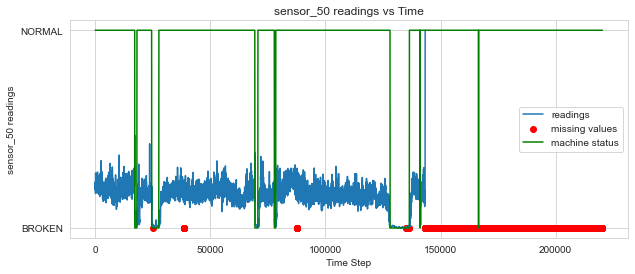

In [18]:
plot_missing('sensor_50', sensor_data)

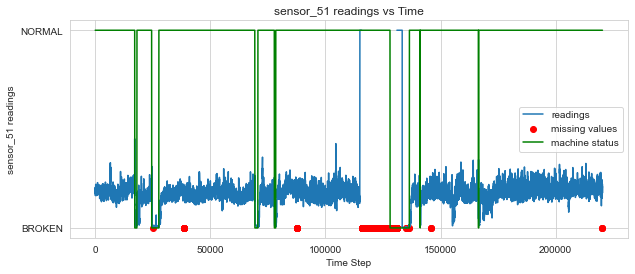

In [19]:
plot_missing('sensor_51', sensor_data)


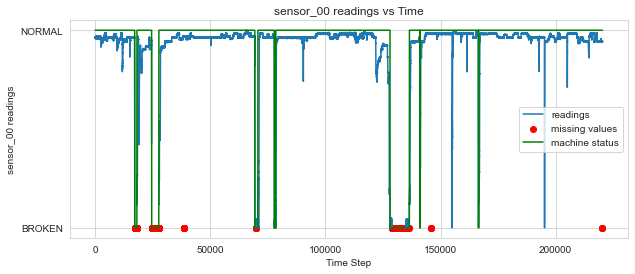

In [20]:
plot_missing('sensor_00', sensor_data)


**Observations**:
* Sensor readings are missing in both NORMAL and BROKEN state
* Most of the data missing in broken state

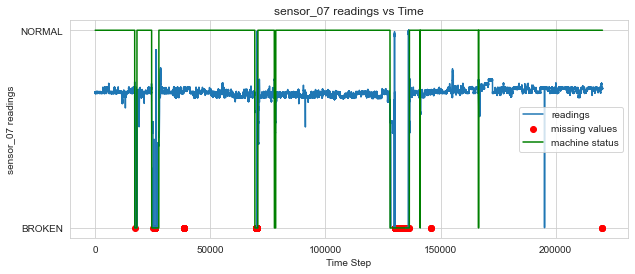

In [21]:
plot_missing('sensor_07', sensor_data)


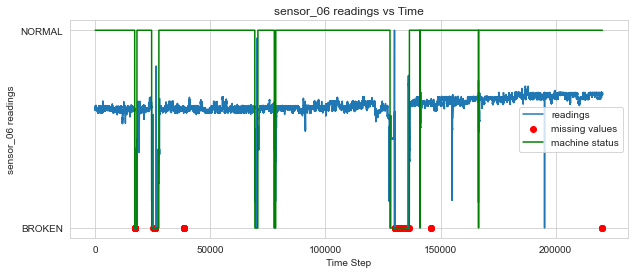

In [22]:
plot_missing('sensor_06', sensor_data)


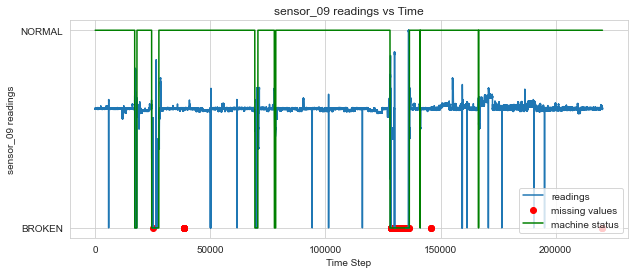

In [23]:
plot_missing('sensor_09', sensor_data)


**Handling Missing Values:
* sensor_15 is dropped as all of its values are missing
* For all other sensors, most of the values are missing in Broken state so filled with out of distribution value, -1

In [24]:
# dropping columns machine_status, new_machine_status and sensor_15
sensor_data = sensor_data.drop(columns=['machine_status', 
                                        'new_machine_status', 
                                        'sensor_15'], axis=1)
# dropping column unnamed
sensor_data = sensor_data.drop(sensor_data.columns[0], axis=1)

# filling missing values with -1
for sensor in list(sensor_data.columns)[1:-1]:
    sensor_data[sensor].fillna(-1, inplace=True)

In [25]:
sensor_data.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,label
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,0
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,0
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,0
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,0
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,0


### Feature Engineering - I
Because of limited availability data, selected time window of 10 minute for prediction i. e. given a data point predict the machine status after 10 minute. Therefore data is pre-processed by shifting the labels by 10 minute.

In [26]:
def shift_labels(sensor_list, df):
    """
    Function to shift labels by 10 min
    """
    new_features = {}

    for sensor in sensor_list:
        new_features[sensor] = df[sensor]

    labels = [None] * df.shape[0]

    for i in range(0, df.shape[0]-10):
        labels[i] = sensor_data['label'][i+10]
    
    new_features['label'] = labels
    new_df = pd.DataFrame(new_features)
    # dropping last rows with null value
    new_df.drop(new_df.tail(10).index,inplace=True)
    return new_df

In [27]:
data_10min_shift = shift_labels(sensor_data.columns[1:-1], sensor_data)
data_10min_shift.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,label
0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,0.0
1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,0.0
2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,0.0
3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,0.0
4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,0.0


**Distribution plot**

For selecting best features, distribution of sensor readings corresponding to Noraml class and Broken class is plotted

In [28]:
def get_distrib_plot(sensor, df):
    """
    Function to plot distribution of sensor readings for Normal and Broken state
    """
    # sensor values corrensponding machine status Normal
    normal = df[df['label']==0][sensor].values
    # sensor values corrensponding machine status Broken
    broken = df[df['label']==1][sensor].values

    plt.figure(figsize=(10,3))
    # distribution for normal state
    sns.distplot(normal, hist=False, label="Normal") 
    # distribution for broken state
    sns.distplot(broken, hist=False, label="Broken") 
    plt.title('Distribution of sensor readings corresponding Normal and Broken state')
    plt.xlabel(f'{sensor} readings')
    plt.legend()
    plt.show()

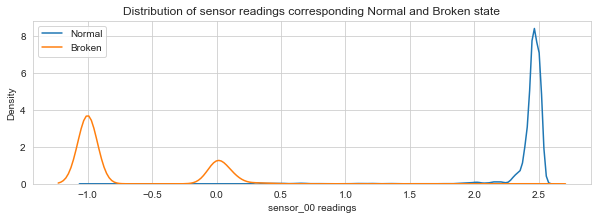

In [29]:
get_distrib_plot('sensor_00', data_10min_shift)


**Observations:
* From the plot we can see that sensor_00 distribution in normal state and broken state is well seperated
* This feature is useful for classifying normal and broken state

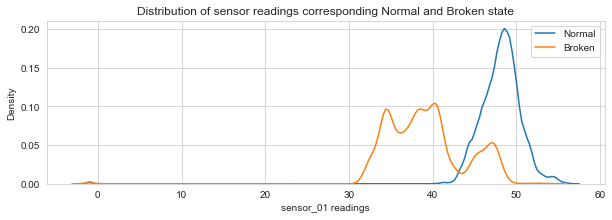

In [30]:
get_distrib_plot('sensor_01', data_10min_shift)

**Observations:**

There is overlap between normal state and broken state distribution

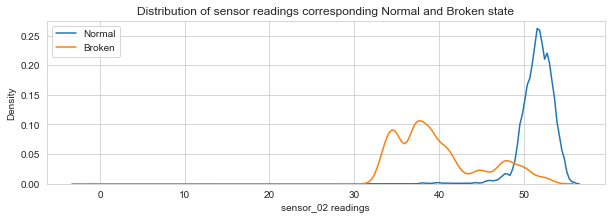

In [31]:
get_distrib_plot('sensor_02', data_10min_shift)


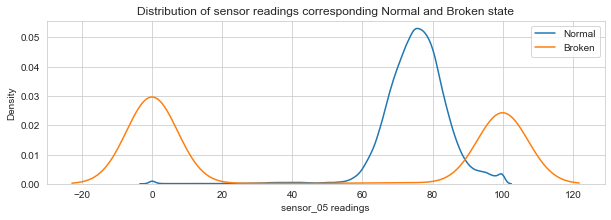

In [32]:
get_distrib_plot('sensor_05', data_10min_shift)


**Observations:**
* There is lot overlap between normal state and broken state distribution
* This feature is **not** useful for classification

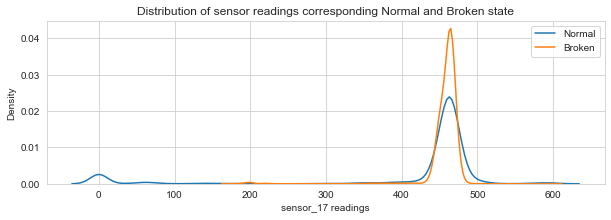

In [33]:
get_distrib_plot('sensor_17', data_10min_shift)

**Observations:**
* There is lot overlap between normal state and broken state distribution
* This feature is not useful for classification

**Feature Selection:**

sensor_00, sensor_04, sensor_06, sensor_07, sensor_08, sensor_09, sensor_10, sensor_11
and sensor_12 are selected for training a classification model

In [34]:
final_sensors = ['sensor_00', 'sensor_04', 'sensor_06', 'sensor_07', 
                 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 
                 'sensor_12']

**New feature:**

for seleceted sensors distance from normal state's mean value is calculated

In [35]:
def get_new_features(sensor_list, df):
    """
    Function to find distance from normal state mean value 
    """
    new_features = {}
    for sensor in sensor_list:
        val = df[sensor] - np.mean(df[df['label']==0][sensor].values)
        new_features[sensor] = val
    new_features['label'] = df['label']
    new_df = pd.DataFrame(new_features)
    return new_df

In [36]:
# dist from mean of normal state
df_dist_from_norm_mean = get_new_features(final_sensors, data_10min_shift)
df_dist_from_norm_mean.head()

,sensor_00,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,label
0,0.045599,8.811367,-0.452019,-0.033137,0.090218,-0.03195,-7.029786,2.768899,-0.045803,0.0
1,0.045599,8.811367,-0.452019,-0.033137,0.090218,-0.03195,-7.029786,2.768899,-0.045803,0.0
2,0.024939,13.325267,-0.538829,-0.127167,0.140858,-0.07535,-6.389416,3.421909,0.925977,0.0
3,0.040679,2.561367,-0.546059,0.082613,0.220428,-0.00301,-5.677416,3.900749,0.509247,0.0
4,0.025923,10.894667,-0.509889,0.046443,0.220428,-0.00301,-4.767796,4.307659,0.789057,0.0


## EDA Summary

* Dataset contains 3 classes namely Normal, Recovering and Broken. 205836 data points belongs to Normal class, 14477 data points belongs to Recovering class and 7 data points belongs to Broken class

* Plot of machine status variation with time shows that Recovering state follows Broken state and in Recovering state pump is trying to recover from Broken state so Recoverting state is considered as Broken state

* After relabeling, 205836 data points belongs to Normal class and 14484 data points belongs to Broken class

* While checking for missing values we found that all the sensors have missing values, all of the sensor_15 readings are missing, 34% of sensor_50 readings are missing, 6% of sensor_51 readings are missing, 4% of sensor_00 readings are missing and all other sensors have less than 2% missing values

* We noticed from missing value plot that sensor readings are missing in both Normal and Broken state also most of the data is missing in Broken state
Sensor_15 is dropped from the dataset as all of its values and missing and for all other sensors missing values are filled with out of distribution value, -1 Selected time window of 10 minute for prediction and data is pre-processed by shifting the labels by 10 minute.

* Feature selection is carried out by comparing distribution of sensor readings in Normal state and Broken and selected the sensors with least overlap

* Selected sensor_00, sensor_04, sensor_06, sensor_07, sensor_08, sensor_09, sensor_10, sensor_11 and sensor_12 as final features. New features are created by calculating distance from Normal state's mean value

# Splitting the data


In [37]:
def percentage_cls_distrib(df):
    """
    function to get % class distribution among train and test data
    """
    total = len(df)
    class_0 = round(df.value_counts()[0] *100 / total, 2)
    class_1 = round(df.value_counts()[1] *100 / total, 2)
    print(f"% Normal class data points = {class_0}")
    print(f"% Broken class data points= {class_1}")

In [38]:
# y data
data_y = df_dist_from_norm_mean['label']
# x data
data_x = df_dist_from_norm_mean.drop(columns='label')

train_dataPoints = 131000

X_train = data_x[:train_dataPoints]
y_train = data_y[:train_dataPoints]

X_test = data_x[train_dataPoints: ]
y_test = data_y[train_dataPoints: ]

Training data



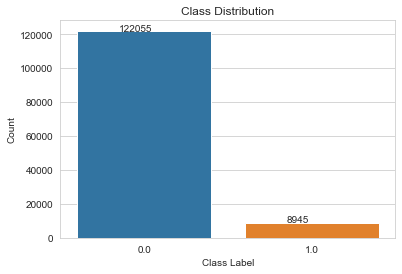

% Normal class data points = 93.17
% Broken class data points= 6.83


In [39]:
print("Training data")
print()
get_class_distribution(y_train)
percentage_cls_distrib(y_train)

Test data



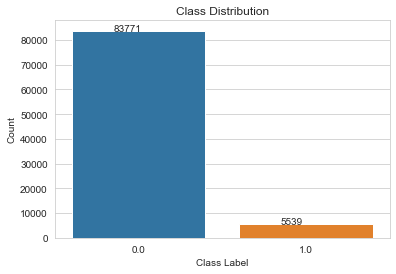

% Normal class data points = 93.8
% Broken class data points= 6.2


In [40]:
print("Test data")
print()
get_class_distribution(y_test)
percentage_cls_distrib(y_test)

# Scaling the data

In [41]:
def normalize_df(df_train, df_test):
    """
    Function to normalize the data using minimax scaler
    """
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(df_train.values)
    scaled_test = scaler.transform(df_test.values)
    train = pd.DataFrame(data=scaled_train, 
                         columns=df_train.columns, 
                         index=df_train.index)
    test = pd.DataFrame(data=scaled_test, 
                        columns=df_test.columns, 
                        index=df_test.index)
    return train, test

In [42]:
X_train, X_test = normalize_df(X_train, X_test)


In [43]:
X_train.head()


,sensor_00,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0.976438,0.793227,0.619817,0.698958,0.681570,0.689154,0.495772,0.795479,0.698199
1,0.976438,0.793227,0.619817,0.698958,0.681570,0.689154,0.495772,0.795479,0.698199
2,0.970617,0.798863,0.616083,0.695122,0.683654,0.687291,0.504077,0.806184,0.719325
3,0.975052,0.785424,0.615772,0.703681,0.686927,0.690396,0.513311,0.814034,0.710265
4,0.970894,0.795828,0.617328,0.702205,0.686927,0.690396,0.525107,0.820705,0.716348


In [44]:
X_test.head()

,sensor_00,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
131000,0.0,0.005558,0.0,0.0,0.0,0.0,0.016478,0.017532,0.021739
131001,0.0,0.005414,0.0,0.0,0.0,0.0,0.016478,0.017532,0.021739
131002,0.0,0.005414,0.0,0.0,0.0,0.0,0.016478,0.017532,0.021739
131003,0.0,0.005125,0.0,0.0,0.0,0.0,0.016478,0.017532,0.021739
131004,0.0,0.004742,0.0,0.0,0.0,0.0,0.016478,0.017532,0.021739


# Modeling-I


In [45]:
# time splitting of the data for cross validation
folds = TimeSeriesSplit(n_splits=5)

In [46]:
def get_cv_plot(validation, parameter):
    """
    Function to plot cross validation metric
    """
    # creating dataframe of cross validation results
    results = pd.DataFrame.from_dict(validation.cv_results_)
    results = results.sort_values([parameter])

    # Get Mean score for each grid search for train data
    train_macro_f1= validation.cv_results_['mean_train_score']
    # Get Mean score for each grid search for cross validation data
    cv_macro_f1 = validation.cv_results_['mean_test_score'] 
    C =  results[parameter]

    # plotting the results
    plt.figure(figsize=(7,4))
    plt.plot(C, train_macro_f1, label='Train macro f1')
    plt.plot(C, cv_macro_f1, label='CV macro f1')
    plt.scatter(C, train_macro_f1, label='Train macro f1 points')
    plt.scatter(C, cv_macro_f1, label='CV macro f1 points')

    plt.xscale('log')
    plt.legend()
    plt.xlabel("hyperparameter")
    plt.ylabel("macro f1-score")
    plt.title("Macro f1-score Vs Hyperparameter")
    plt.grid( linestyle='-', linewidth=0.5)
    plt.grid()
    plt.show()

In [47]:
def get_confusion_mat( y_true , y_pred):
    """
    Function to plot confusion matrix
    """
    # counfusion matrix
    confusion_mat = confusion_matrix(y_true , y_pred)
        
    labels = ["Normal", "Broken"]

    # plot heat map of confusion matrix
    sns.heatmap(confusion_mat, annot=True, fmt='', cmap='Greens',
                xticklabels=labels, 
                yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [48]:
def get_result( model , x_test , y_test ):
    """
    Function to check model performance on test data and print the metric
    """
    # prediction on test data
    y_pred = model.predict(x_test) 
    # get the metric
    f1_macro = f1_score(y_test, y_pred, average='macro')
    print(f"Macro F1-Score:{round(f1_macro, 4)} ")
    print()

    print("Confusion Matrix")
    get_confusion_mat(y_test, y_pred)

In [49]:
def get_cv_heatmap(validation):
    """
    Function to plot heat map of cross validation results
    """
    # reference: https://stackoverflow.com/questions/48791709/how-to-plot-a-
    # heat-map-on-pivot-table-after-grid-search

    # Get Mean score for each grid search for train data
    train = pd.pivot_table(pd.DataFrame(validation.cv_results_),
                              values='mean_train_score', 
                           index='param_max_depth', 
                           columns='param_n_estimators')

    # Get Mean score for each grid search for cross validation data
    test = pd.pivot_table(pd.DataFrame(validation.cv_results_),
                            values='mean_test_score', 
                          index='param_max_depth', 
                          columns='param_n_estimators')
    
    # plotting the results
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(17,5))
    sns.heatmap(train, annot=True, 
                cmap="Greens", 
                fmt='.3g', ax=ax1).set_title('macro f1-score (Training data)')
    sns.heatmap(test, annot=True, 
                cmap="Greens", 
                fmt='.3g', ax=ax2).set_title('macro f1-score (CV data)')

## Logistic Regression
### Hyperparameter tuning

In [50]:
# Logistic regression model
log_reg = LogisticRegression(n_jobs=-1, random_state=21)

# parameter to tune
# C: Inverse of regularization strength
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# defining model to tune hyperparameter
clf = GridSearchCV(estimator=log_reg,
                        param_grid=param_grid,
                        cv=folds,
                        scoring='f1_macro',
                        n_jobs=-1,
                        return_train_score=True)

# fit the model to train data
clf.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LogisticRegression(n_jobs=-1, random_state=21),
             n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='f1_macro')

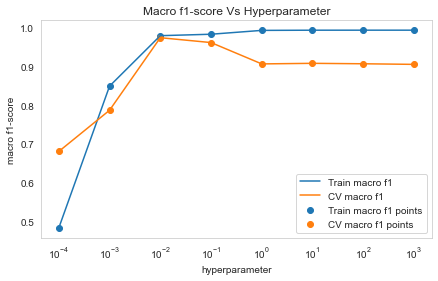

In [51]:
# plotting cross validation result
get_cv_plot(clf, 'param_C')

**Observations:**
* for C = 0.01 both train and cross validation metric (macro f1_score) is high
* best parameter C = 0.01

In [52]:
# C:Inverse of regularization strength
param_C = 0.01

Macro F1-Score:0.9837 

Confusion Matrix


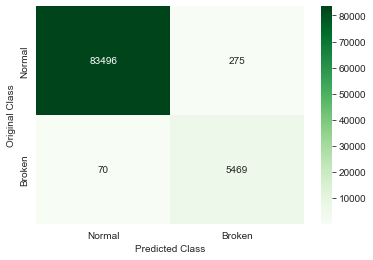

In [53]:
# traing with best C value
log_reg = LogisticRegression(C=param_C, n_jobs=-1, random_state=21)
log_reg.fit(X_train, y_train)
get_result(log_reg, X_test, y_test)

**Observations:**
* Macro F1-Score of 0.9837 is obtained
* Model correctly classified 83496 Normal class data points and 5469 Broken class data points
* Model misclassified 275 Normal class data points as Broken and 70 Broken class data points as Normal
* Total misclassification count is 345

## SVM:
### Hyperparameter tuning

In [54]:
# svm model
svm_clf = SGDClassifier(loss='hinge', penalty='l2', n_jobs=-1, random_state=21)

# parameter to tune
# alpha: regularization strength
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# defining model to tune hyperparameter
svm_cv = GridSearchCV(estimator=svm_clf,
                        param_grid=param_grid,
                        cv=folds,
                        scoring='f1_macro',
                        n_jobs=-1,
                        return_train_score=True)

# fit the model to train data
svm_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SGDClassifier(n_jobs=-1, random_state=21), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='f1_macro')

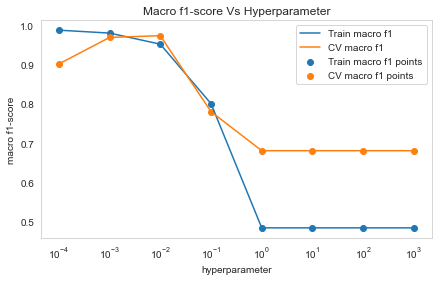

In [55]:
# plotting cross validation result
get_cv_plot(svm_cv, 'param_alpha')

**Observations:**
* for alpha = 0.01 both train and cross validation metric (macro f1_score) is high
* best parameter alpha = 0.01

In [56]:
# alpha: regularization strength
param_alpha = 0.01

Macro F1-Score:0.964 

Confusion Matrix


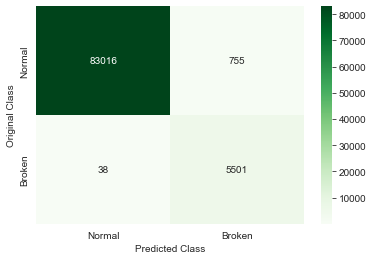

In [57]:
# traing with best alpha value
svm_clf = SGDClassifier(loss='hinge', alpha=param_alpha, penalty='l2', 
                        n_jobs=-1, random_state=21)
svm_clf.fit(X_train, y_train)

get_result(svm_clf, X_test, y_test)

**Observations:**
* Macro F1-Score of 0.964 is obtained
* Model correctly classified 83016 Normal class data points and 5501 Broken class data points
* Model misclassified 755 Normal class data points as Broken and 38 Broken class data points as Normal
* Total misclassification count is 793

## Random Forest:
### Hyperparameter tuning

In [58]:
# random forest model
r_forest_clf = RandomForestClassifier(criterion='gini', 
                                      random_state=21, 
                                      n_jobs=-1)

# parameter to tune
# n_estimators: number of estimators
# max_depth: maximum depth of the tree
param_grid = {'n_estimators': [10, 25, 50, 100,150, 200],
                'max_depth': [1, 3, 5, 10, 20, 30, 50]}

# defining model to tune hyperparameter
r_forest_cv = GridSearchCV(estimator=r_forest_clf,
                        param_grid=param_grid,
                        cv=folds,
                        scoring='f1_macro',
                        n_jobs=-1,
                        return_train_score=True)

r_forest_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=21),
             n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 10, 20, 30, 50],
                         'n_estimators': [10, 25, 50, 100, 150, 200]},
             return_train_score=True, scoring='f1_macro')

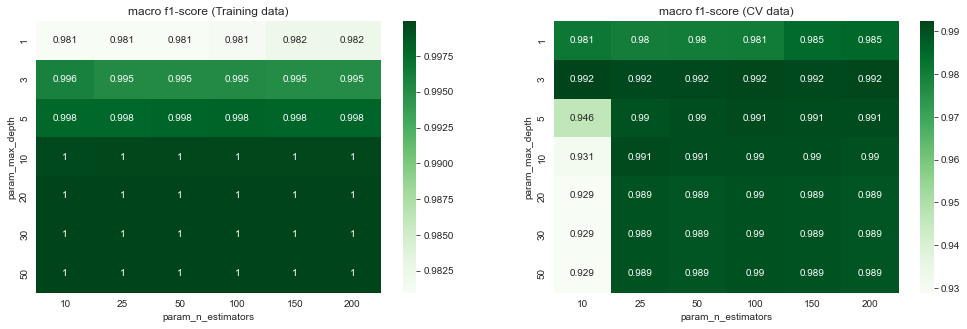

In [59]:
# plotting cross validation result
get_cv_heatmap(r_forest_cv)

*Observations:*

* From the heatmap optimum values are considered
* Optimum max_depth = 5
* Optimum n_estimators = 25

In [60]:
# max_depth: maximum depth of the tree
max_depth = 5
# n_estimators: number of estimators
n_estimator = 25

Macro F1-Score:0.9968 

Confusion Matrix


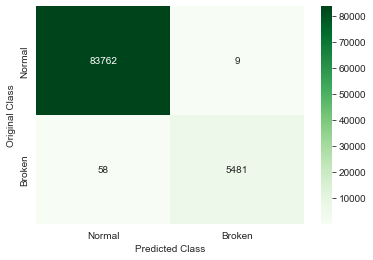

In [61]:
# traing with optimum tree depth and number of estimators
r_forest_clf = RandomForestClassifier(n_estimators=n_estimator, criterion='gini', 
max_depth=max_depth, random_state=21, n_jobs=-1)

r_forest_clf.fit(X_train, y_train)

get_result(r_forest_clf, X_test, y_test)

*Observations*:
* Macro F1-Score of 0.9968 is obtained
* Model correctly classified 83762 Normal class data points and 5481 Broken class data points
* Model misclassified 9 Normal class data points as Broken and 58 Broken class data points as Normal
* Total misclassification count is 67

## XGBoost
### Hyperparameter tuning

In [62]:
# XGBoost classifier
xgb_clf = XGBClassifier()

# parameter to tune
# n_estimators: number of estimators
# max_depth: maximum depth of the tree
param_grid = {'n_estimators': [5, 10, 20, 30, 40, 50],
                'max_depth': [1, 3, 5, 7, 10, 20, 30]}

# defining model to tune hyperparameter
xgb_cv = GridSearchCV(estimator=xgb_clf,
                        param_grid=param_grid,
                        cv=folds,
                        scoring='f1_macro',
                        n_jobs=-1,
                        return_train_score=True)

# fit model to train data
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, sub

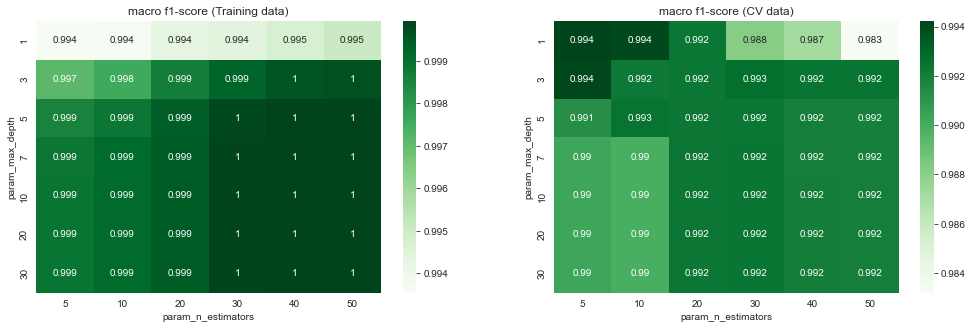

In [63]:
# plotting cross validation result
get_cv_heatmap(xgb_cv)

**Observations:**
* From the heatmap optimum values are considered
* Optimum max_depth = 1
* Optimum n_estimators = 5

In [64]:
# optimum parameters
max_depth = 1
n_estimator = 5

In [65]:
# traing with optimum tree depth and number of estimators
xgb_clf = XGBClassifier(n_estimators=n_estimator, max_depth=max_depth)

xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=5, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Macro F1-Score:0.9963 

Confusion Matrix


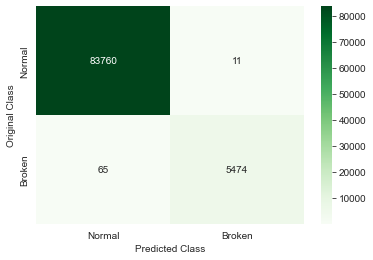

In [66]:
get_result(xgb_clf, X_test, y_test)

**Observations:**
* Macro F1-Score of 0.9963 is obtained
* Model correctly classified 83760 Normal class data points and 5474 Broken class data points
* Model misclassified 11 Normal class data points as Broken and 65 Broken class data points as Normal
* Total misclassification count is 76


## In order to improve the model performace we also trained models on Mean features
### Feature Engineering - II
* Selected time window of 10 minute for prediction and considered mean value of 10 min time window

In [67]:
def get_mean_features(sensor_list, df):
    """
    Function to get mean val of 10min window
    """

    new_features = {}

    # looping over all sensors and calculating mean of 10 values
    for sensor in sensor_list:
        new_features[sensor] = df[sensor].rolling(10).mean().values

    labels = []
    # creating list with None value
    labels = [None] * (df.shape[0])

    for i in range(0, df.shape[0]-10):
        labels[i+9] = df['label'][i+10]

    new_features['label'] = labels

    # creating dataframe
    new_df = pd.DataFrame(new_features)
    # removing first 9 rows with null values
    new_df.drop(new_df.head(9).index, inplace=True)
    # resetting index 
    new_df.reset_index(inplace=True, drop=True)
    # dropping last row with null value
    new_df.drop(new_df.tail(1).index, inplace=True)
    return new_df

In [68]:
# mean value dataframe
data_mean_vals = get_mean_features(sensor_data.columns[1:-1], sensor_data)
data_mean_vals.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,label
0,2.454966,47.131073,53.18576,46.380206,634.75692,75.898200,13.358651,16.155959,15.698062,15.084637,...,42.057288,38.888888,62.615740,51.186343,38.715276,166.98494,67.795142,242.27431,201.64930,0.0
1,2.454867,47.170136,53.17708,46.388887,635.09256,75.857373,13.358651,16.159576,15.706742,15.091147,...,42.005205,38.859953,61.545138,51.186343,38.831017,170.28355,68.142364,243.05556,201.50462,0.0
2,2.452801,47.252601,53.17274,46.397568,635.21988,75.670052,13.358651,16.163193,15.734954,15.097657,...,41.979163,38.831018,60.358795,51.215278,38.917823,173.84258,68.605326,244.06829,201.38888,0.0
3,2.454375,47.343747,53.16406,46.397568,634.34025,76.011442,13.360821,16.176213,15.746528,15.097657,...,42.083330,38.831018,59.143517,51.186343,39.004629,177.80671,69.126159,245.25464,201.24420,0.0
4,2.453195,47.478296,53.16406,46.397568,635.39349,75.879854,13.360821,16.168255,15.761719,15.106337,...,42.265622,38.975694,58.043980,51.128472,39.091435,181.85764,69.733797,246.49885,201.21526,0.0


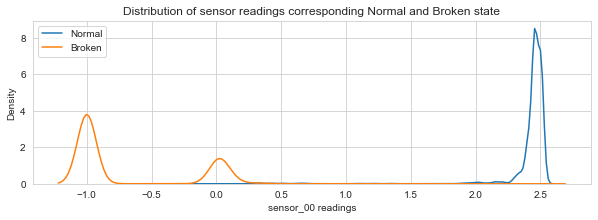

In [72]:
get_distrib_plot('sensor_00', data_mean_vals)
#Observations:
#From the plot we can see that sensor_00 distribution in normal state and broken state is well separated
# This feature is useful for classifying normal and broken state

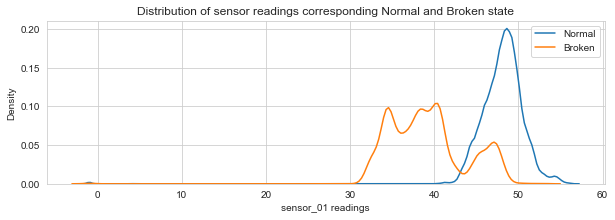

In [71]:
get_distrib_plot('sensor_01', data_mean_vals)
# Observations:
# There is overlap between normal state and broken state distribution

**Feature Selection:**

sensor_00, sensor_04, sensor_06, sensor_07, sensor_08, sensor_09, sensor_10,
sensor_11 and sensor_12 are selected for training a classification model

In [73]:
final_sensors = ['sensor_00', 'sensor_04', 'sensor_06', 'sensor_07', 
                 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 
                 'sensor_12']

In [74]:
# dataframe of final sensors
df_mean_vals = data_mean_vals[final_sensors]
df_mean_vals['label'] = data_mean_vals['label']
df_mean_vals.head()

,sensor_00,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,label
0,2.454966,634.75692,13.358651,16.155959,15.698062,15.084637,38.330033,48.994831,31.842780,0.0
1,2.454867,635.09256,13.358651,16.159576,15.706742,15.091147,38.597492,49.291350,32.011140,0.0
2,2.452801,635.21988,13.358651,16.163193,15.734954,15.097657,38.853273,49.617748,32.213983,0.0
3,2.454375,634.34025,13.360821,16.176213,15.746528,15.097657,39.070780,49.850504,32.351415,0.0
4,2.453195,635.39349,13.360821,16.168255,15.761719,15.106337,39.303099,50.081416,32.547885,0.0


In [75]:
## Splitting the data
# y data
data_y = df_mean_vals['label']
# x data
data_x = df_mean_vals.drop(columns='label')

train_dataPoints = 131000

X_train = data_x[:train_dataPoints]
y_train = data_y[:train_dataPoints]

X_test = data_x[train_dataPoints : ]
y_test = data_y[train_dataPoints : ]

Training data



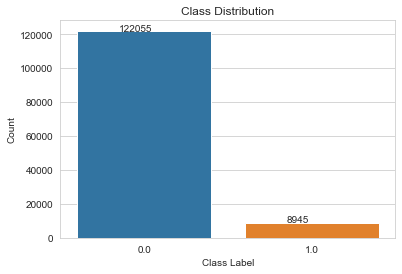

% Normal class data points = 93.17
% Broken class data points= 6.83


In [76]:
print("Training data")
print()
get_class_distribution(y_train)
percentage_cls_distrib(y_train)

Test data



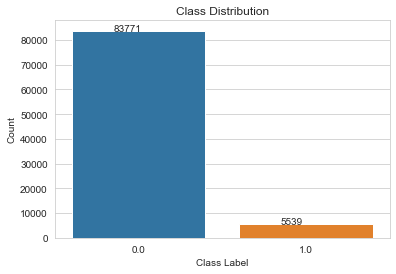

% Normal class data points = 93.8
% Broken class data points= 6.2


In [77]:
print("Test data")
print()
get_class_distribution(y_test)
percentage_cls_distrib(y_test)

## Scaling the data


In [78]:
X_train, X_test = normalize_df(X_train, X_test)

In [79]:
X_train.head()

,sensor_00,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0.975636,0.958281,0.664295,0.710276,0.689831,0.695478,0.533461,0.816886,0.738610
1,0.975608,0.958790,0.664295,0.710426,0.690190,0.695759,0.537183,0.821820,0.742503
2,0.975025,0.958983,0.664295,0.710575,0.691355,0.696041,0.540743,0.827250,0.747193
3,0.975469,0.957649,0.664395,0.711115,0.691833,0.696041,0.543770,0.831123,0.750371
4,0.975136,0.959247,0.664395,0.710785,0.692461,0.696416,0.547004,0.834965,0.754914


In [80]:
X_test.head()

,sensor_00,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
131000,0.0,0.000507,0.0,0.0,0.0,0.0,0.003765,0.002819,0.002312
131001,0.0,0.000461,0.0,0.0,0.0,0.0,0.003765,0.002819,0.002312
131002,0.0,0.000414,0.0,0.0,0.0,0.0,0.003765,0.002819,0.002312
131003,0.0,0.000414,0.0,0.0,0.0,0.0,0.003765,0.002819,0.002312
131004,0.0,0.000420,0.0,0.0,0.0,0.0,0.003765,0.002819,0.002312


## Modeling-II
### Logistic Regression
#### Hyperparameter tuning

In [81]:
# Logistic regression model
log_reg = LogisticRegression(n_jobs=-1, random_state=21)

# parameter to tune
# C: Inverse of regularization strength
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# defining model to tune hyperparameter
clf = GridSearchCV(estimator=log_reg,
                        param_grid=param_grid,
                        cv=folds,
                        scoring='f1_macro',
                        n_jobs=-1,
                        return_train_score=True)

# fit the model to train data
clf.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LogisticRegression(n_jobs=-1, random_state=21),
             n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='f1_macro')

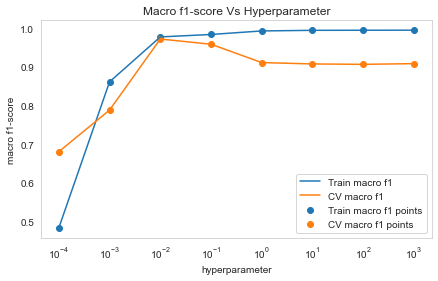

In [82]:
# plotting cross validation result
get_cv_plot(clf, 'param_C')

**Observations:**
* for C = 0.01 both train and cross validation metric (macro f1_score) is high
* best parameter C = 0.01

In [83]:
# C:Inverse of regularization strength
param_C = 0.01

Macro F1-Score:0.9844 

Confusion Matrix


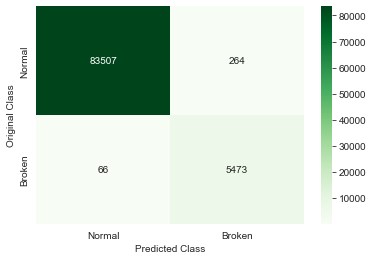

In [84]:
# traing with best C value
log_reg = LogisticRegression(C=param_C, n_jobs=-1, random_state=21)
log_reg.fit(X_train, y_train)
get_result(log_reg, X_test, y_test)

**Observations:**
* Macro F1-Score of 0.9844 is obtained
* Model correctly classified 83507 Normal class data points and 5473 Broken class data points
* Model misclassified 264 Normal class data points as Broken and 66 Broken class data points as Normal
* Total misclassification count is 330
## SVM:
### Hyperparameter tuning

In [85]:
# svm model
svm_clf = SGDClassifier(loss='hinge', penalty='l2', n_jobs=-1, random_state=21)

# parameter to tune
# alpha: regularization strength
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# defining model to tune hyperparameter
svm_cv = GridSearchCV(estimator=svm_clf,
                        param_grid=param_grid,
                        cv=folds,
                        scoring='f1_macro',
                        n_jobs=-1,
                        return_train_score=True)

# fit the model to train data
svm_cv.fit(X_train, y_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SGDClassifier(n_jobs=-1, random_state=21), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='f1_macro')

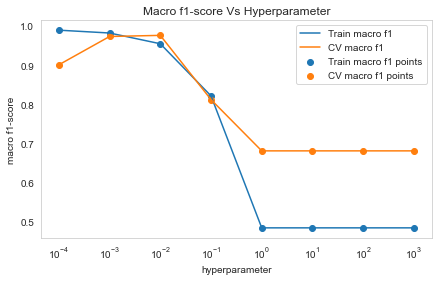

In [86]:
# plotting cross validation result
get_cv_plot(svm_cv, 'param_alpha')

**Observations:**
* for alpha = 0.01 both train and cross validation metric (macro f1_score) is high
* best parameter alpha = 0.01

In [87]:
# alpha: regularization strength
param_alpha = 0.01

Macro F1-Score:0.9637 

Confusion Matrix


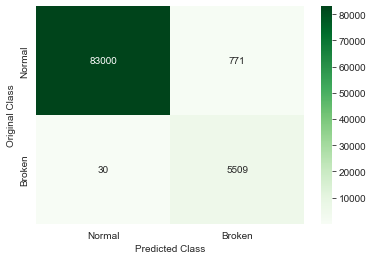

In [88]:
# traing with best alpha value
svm_clf = SGDClassifier(loss='hinge', alpha=param_alpha, penalty='l2', 
                        n_jobs=-1, random_state=21)
svm_clf.fit(X_train, y_train)
get_result(svm_clf, X_test, y_test)

**Observations:**
* Macro F1-Score of 0.9637 is obtained
* Model correctly classified 83000 Normal class data points and 5509 Broken class data points
* Model misclassified 771 Normal class data points as Broken and 30 Broken class data points as Normal
* Total misclassification count is 801

## Random Forest:
### Hyperparameter tuning

In [90]:
# random forest model
r_forest_clf = RandomForestClassifier(criterion='gini', 
                                      random_state=21, 
                                      n_jobs=-1)

# parameter to tune
# n_estimators: number of estimators
# max_depth: maximum depth of the tree
param_grid = {'n_estimators': [10, 20, 30, 40, 50],
                'max_depth': [1, 3, 5, 10, 30]}

# defining model to tune hyperparameter
r_forest_cv = GridSearchCV(estimator=r_forest_clf,
                        param_grid=param_grid,
                        cv=folds,
                        scoring='f1_macro',
                        n_jobs=-1,
                        return_train_score=True)

r_forest_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=21),
             n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 10, 30],
                         'n_estimators': [10, 20, 30, 40, 50]},
             return_train_score=True, scoring='f1_macro')

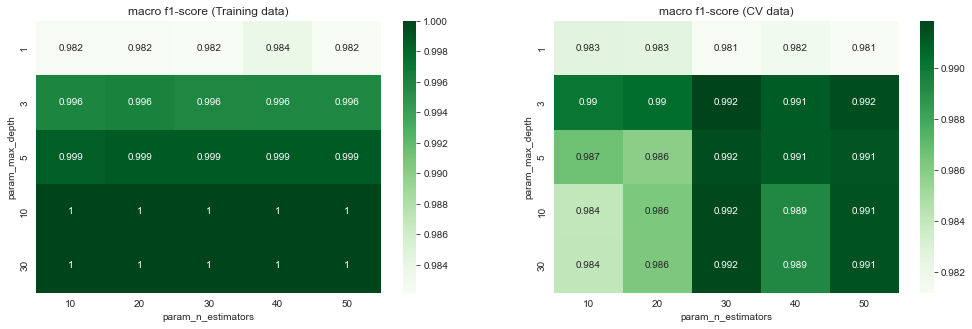

In [91]:
# plotting cross validation result
get_cv_heatmap(r_forest_cv)

In [92]:
# # optimum parameters
# n_estimator = 10
# max_depth = 3

# max_depth: maximum depth of the tree
max_depth = 3
# n_estimators: number of estimators
n_estimator = 10

Macro F1-Score:0.9973 

Confusion Matrix


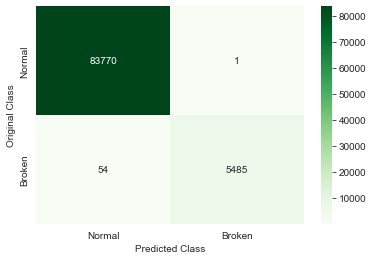

In [93]:
# traing with optimum tree depth and number of estimators
r_forest_clf = RandomForestClassifier(n_estimators=n_estimator, criterion='gini', 
max_depth=max_depth, random_state=21, n_jobs=-1)

r_forest_clf.fit(X_train, y_train)

get_result(r_forest_clf, X_test, y_test)

**Observations:**
* Macro F1-Score of 0.9973 is obtained
* Model correctly classified 83770 Normal class data points and 5485 Broken class data points
* Model misclassified 1 Normal class data points as Broken and 54 Broken class data points as Normal
* Total misclassification count is 55

## XGBoost
### Hyperparameter tuning

In [94]:
# XGBoost model
xgb_clf = XGBClassifier()

# parameter to tune
# n_estimators: number of estimators
# max_depth: maximum depth of the tree
param_grid = {'n_estimators': [5, 10, 20, 30, 40, 50],
                'max_depth': [1, 3, 5, 7, 10, 20]}

# defining model to tune hyperparameter
xgb_cv = GridSearchCV(estimator=xgb_clf,
                        param_grid=param_grid,
                        cv=folds,
                        scoring='f1_macro',
                        n_jobs=-1,
                        return_train_score=True)

xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, sub

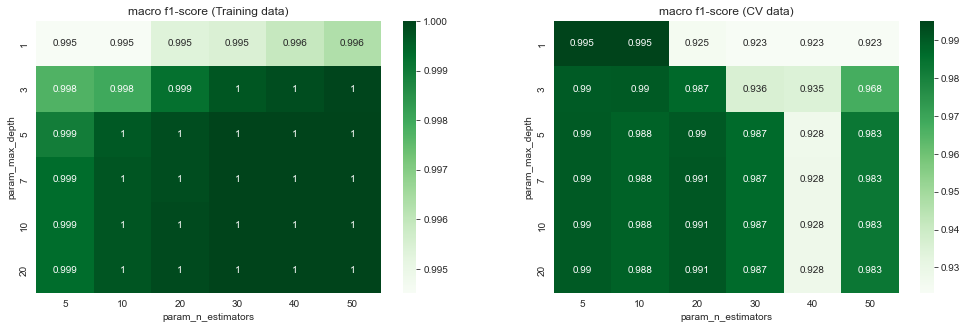

In [95]:
# plotting cross validation result
get_cv_heatmap(xgb_cv)

In [96]:
# max_depth: maximum depth of the tree
max_depth = 1
# n_estimators: number of estimators
n_estimator = 5

In [97]:
# traing with optimum tree depth and number of estimators
xgb_clf = XGBClassifier(n_estimators=n_estimator, max_depth=max_depth)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=5, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Macro F1-Score:0.9973 

Confusion Matrix


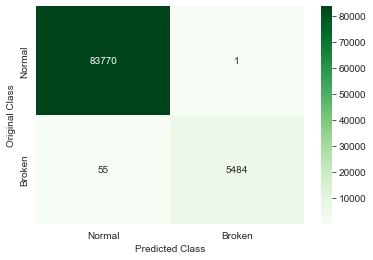

In [98]:
get_result(xgb_clf, X_test, y_test)

**Observations:**
* Macro F1-Score of 0.9973 is obtained
* Model correctly classified 83770 Normal class data points and 5484 Broken class data points
* Model misclassified 1 Normal class data points as Broken and 55 Broken class data points as Normal
* Total misclassification count is 56

# Summary

In [99]:
table = PrettyTable()
table.field_names = ["Model", "Feature", "Macro_F1", "Misclassifications"]
table.add_row(["Logistic Regression", " ", 0.9837, 345])
table.add_row(["SVM", " Distance from mean", 0.9640, 793])
table.add_row(["Random Forest", "of normal state", 0.9968, 67])
table.add_row(["XGBoost", " ", 0.9963, 76])
table.add_row(["-------------------", "------------------", 
"--------", "------------------"])
table.add_row(["Logistic Regression", " ", 0.9844, 330])                              
table.add_row(["SVM", "Mean value of", 0.9637, 801])
table.add_row(["Random Forest", "10 min window", 0.9973, 55])
table.add_row(["XGBoost", " ", 0.9973, 56])
print(table)

+---------------------+---------------------+----------+--------------------+
|        Model        |       Feature       | Macro_F1 | Misclassifications |
+---------------------+---------------------+----------+--------------------+
| Logistic Regression |                     |  0.9837  |        345         |
|         SVM         |  Distance from mean |  0.964   |        793         |
|    Random Forest    |   of normal state   |  0.9968  |         67         |
|       XGBoost       |                     |  0.9963  |         76         |
| ------------------- |  ------------------ | -------- | ------------------ |
| Logistic Regression |                     |  0.9844  |        330         |
|         SVM         |    Mean value of    |  0.9637  |        801         |
|    Random Forest    |    10 min window    |  0.9973  |         55         |
|       XGBoost       |                     |  0.9973  |         56         |
+---------------------+---------------------+----------+--------

# Inference:

Rondom Forest Classifier trained on mean value features is having highest Macro F1-Score and least misclassification count therefore selected as final model for deployment